# **IMAGE CAPTIONING**

**Design a CNN-LSTM system that can perform image captioning that handle Language Bias in LSTM model**

Generating a caption for a given image is a challenging problem in the deep learning domain. In this project, I will use different techniques of computer vision and NLP to recognize the context  of  an  image  and  describe  them  in  a  natural  language  like  English.  we  will  build  a working  model  of  the  image  caption  generator  by  using  CNN  (Convolutional  Neural Networks) and LSTM(Longshort-termmemory) units.

This notebook focuses on the Language Bias problem of LSTM model. The LSTM based image captioning can ‘blindly’ learn the structure of the language and predict meaningful sentences even withoutlearning much insight to the content of the image. This is termed as “language bias” of the system. 

So in the work, I tried to remove the Language Bias problem in Image Captioning.

*Solution By: Ashutosh Soni*

### **Importing Libraries**

In [ ]:
import numpy as np
import os
import string
import matplotlib.pyplot as plt
from PIL import Image
from pickle import dump, load

import torch
import torchvision.models as models
import torch.nn as nn

In [ ]:
image_directory = './images'

captions_file = './Flickr8k_text/Flickr8k.lemma.token.txt'
train_image_file = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_image_file = './Flickr8k_text/Flickr_8k.valImages.txt'
test_image_file = './Flickr8k_text/Flickr_8k.testImages.txt'

preprocessed_text = './preprocessed/descriptions.txt'

### **Helper Functions for Text Preprocessing**

In [ ]:
def get_file_content(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def get_caption_dictionary(filename):
    content = get_file_content(filename)
    captions = content.split('\n')
    descriptions = {}
    for cap in captions[:-1]:
        img, desc = cap.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [desc]
        else:
            descriptions[img[:-2]].append(desc)
    return descriptions

def cleaning(descriptions):
    table = str.maketrans('','',string.punctuation)
    for img, caps in descriptions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            descriptions[img][i]= '<start> ' + img_caption + ' <end>'
    return descriptions

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def generate_word_to_id(desc_list):
    vocab = set()
    for desc in desc_list:
        for w in desc.split(" "):
            vocab.add(w)
    
    word_to_id = {w:i for i, w in enumerate(vocab)}
    id_to_word = {i:w for i, w in enumerate(vocab)}
    
    return word_to_id, id_to_word

def generate_tokens(descriptions):
    desc_list = dict_to_list(descriptions)
    word_to_id, id_to_word = generate_word_to_id(desc_list)
    return word_to_id, id_to_word

In [ ]:
descriptions = get_caption_dictionary(captions_file)
preprocess_descriptions = cleaning(descriptions)

In [ ]:
word_to_id, id_to_word = generate_tokens(preprocess_descriptions)
vocab_size = len(word_to_id)
print("Vocabulary size: ", vocab_size)

Vocabulary size:  6689


### **Image Preprocessing**

In [ ]:
class ImagePreprocessing:
    def __init__(self):
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50_without_top = torch.nn.Sequential(*(list(self.resnet50.children())[:-4]))

    def image_feature_extraction(self, img):
        file = './images/'+img
        image = Image.open(file)
        image_resized = image.resize((250, 250))
        image_input = np.expand_dims(image_resized, axis=0)
        image_input = image_input/127.5
        image_input = image_input - 1.0
        input = torch.from_numpy(image_input)
        processed_image = self.resnet50_without_top(input.permute(0, 3, 1, 2).float())
        # processed_image = self.cnn_top(feature)
        return processed_image

**List of Train, Test and Validation images**

In [ ]:
## Train Images
train_images = []

file_cont = get_file_content(train_image_file)
for img in file_cont.split('\n'):
    train_images.append(img)

## Test Images
test_images = []
file_cont = get_file_content(test_image_file)
for img in file_cont.split('\n'):
    test_images.append(img)

## Validation Images
val_images = []
file_cont = get_file_content(val_image_file)
for img in file_cont.split('\n'):
    val_images.append(img)
print(len(train_images), len(test_images), len(val_images))

6001 1001 1001


### **Image Captioning Model Definition**

- forward(captions, feature): perform the forward propogation(for training);

  - **captions** represent a caption for image whose feature is passed in the **image**
- predict(start, feature, length): perform the prediction(internally forward propogation for test); 
  - **start** represent the starting tag of caption, 
  - **image** represent the test image features and 
  - **length** represent the length of the caption which needs to predicted

In [ ]:
class image_caption(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(image_caption, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = 1

        ## Defining Image feature extraction layers
        ## here we are going to pass this image context in LSTM layer of every word of caption; by which every LSTM can see the whole context of an image
        self.cnn_top = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1),
            nn.MaxPool2d(3, stride=2),
            nn.Tanh(),
            nn.Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1),
            nn.MaxPool2d(3, stride=2),
            nn.Tanh(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(51200, hidden_size)
        )

        ## Defining LSTM related layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)

        self.output = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.y_hat = nn.LogSoftmax(dim=1)

    def forward(self, captions, image):
        outputs = torch.empty((1, captions.size(1), self.vocab_size))

        feature = self.cnn_top(torch.from_numpy(image))
        
        hidden_state = torch.zeros((1, self.hidden_size))
        cell_state = torch.zeros((1, self.hidden_size))
        
        embedding = self.embedding(captions)
        
        for t in range(captions.size(1)):
            ## here we are adding image feature with hidden state to know the context of image in ever LSTM layer
            hidden_state, cell_state = self.lstm(embedding[:, t, :], (hidden_state+feature, cell_state))           
        
            out = self.output(hidden_state)
            tanh = self.tanh(out)
            output = self.y_hat(tanh)
            
            outputs[:, t, :] = output
        return outputs
    
    def predict(self, start, image, length):
        outputs = torch.empty((1, length))
        
        feature = self.cnn_top(torch.from_numpy(image))

        hidden_state = torch.zeros((1, self.hidden_size))
        cell_state = torch.zeros((1, self.hidden_size))
        
        word = torch.from_numpy(np.expand_dims(np.array(start), axis=0))
        
        for t in range(length):
            embedding = self.embedding(word)
            hidden_state, cell_state = self.lstm(embedding[:, 0, :], (hidden_state+feature, cell_state))           
        
            out = self.output(hidden_state)
            tanh = self.tanh(out)
            output = self.y_hat(tanh)
            
            curr_index = np.argmax(output.detach().numpy())
            outputs[:, t] = curr_index
            word = torch.from_numpy(np.expand_dims(np.array([curr_index]), axis=0))
        return outputs

    def initHC(self, hidden_init):
        state_c = torch.zeros(1, self.hidden_size)
        return (torch.from_numpy(hidden_init), state_c)

### **Data Generator**

In [ ]:
def create_sequences(word_to_id, desc, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    in_seq = []
    for w in desc.split(" "):
        in_seq.append(word_to_id[w])
        
    out_seq = in_seq[1:]
    out_seq.append(word_to_id[''])
        
    f_array = np.expand_dims(np.array(feature.detach().numpy()[0]), axis=0)
    input_seq = np.expand_dims(np.array(in_seq), axis=0)
    output_seq = np.expand_dims(np.array(out_seq), axis=0)
        
    return f_array, input_seq, output_seq


# create_sequences(tokenizer, max_length, preprocess_descriptions[train_images[0]], feature)
def data_generator(descriptions, image, feature, word_to_id):
    description_list=descriptions[image]
    for desc in description_list:
        input_image, input_sequence, output_word = create_sequences(word_to_id, desc, feature)
        yield [input_image, input_sequence, output_word]

### **Model Training**

**Initialization of Hyper-parameters**

In [ ]:
vocabulary_size = vocab_size
embed_size = 1024
hidden_size = 1024

**Initialisation of captioning model**

In [ ]:
cap_model = image_caption(vocabulary_size, embed_size, hidden_size)
cap_model

image_caption(
  (cnn_top): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Tanh()
    (4): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=51200, out_features=1024, bias=True)
  )
  (embedding): Embedding(6689, 1024)
  (lstm): LSTMCell(1024, 1024)
  (output): Linear(in_features=1024, out_features=6689, bias=True)
  (tanh): Tanh()
  (y_hat): LogSoftmax(dim=1)
)

**Initialisation of loss function and optimizer for the PyTorch Model**

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(cap_model.parameters(), lr=learning_rate)

**Training**

In [ ]:
image_prep = ImagePreprocessing()

for epoch in range(5):
    loss = 0
    for i in range(len(train_images)):
        image_name = train_images[i]
        if image_name not in os.listdir('./images'):
            continue
            
        processed_image = image_prep.image_feature_extraction(image_name)

        data_gen = data_generator(preprocess_descriptions, image_name, processed_image, word_to_id)

        for _, input in enumerate(data_gen):
            optimizer.zero_grad()

            y_pred = cap_model.forward(torch.from_numpy(input[1]), input[0])
            
            loss +=  cross_entropy(y_pred.transpose(1, 2), torch.from_numpy(input[2]).type(torch.LongTensor))

        if i%24 == 0:
            loss.backward()
            optimizer.step()
            print("Epoch {}, batch {} and loss {}".format(epoch+1, i/24, loss))
            loss = 0
        
        if i == 50:
            break

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1, batch 0.0 and loss 43.98549270629883
Epoch 1, batch 1.0 and loss 1037.7459716796875
Epoch 1, batch 2.0 and loss 922.7850341796875
Epoch 2, batch 0.0 and loss 35.18968200683594
Epoch 2, batch 1.0 and loss 892.3152465820312
Epoch 2, batch 2.0 and loss 835.5620727539062
Epoch 3, batch 0.0 and loss 35.375484466552734
Epoch 3, batch 1.0 and loss 866.0173950195312
Epoch 3, batch 2.0 and loss 823.7818603515625
Epoch 4, batch 0.0 and loss 35.75385665893555
Epoch 4, batch 1.0 and loss 858.4833374023438
Epoch 4, batch 2.0 and loss 823.905029296875
Epoch 5, batch 0.0 and loss 35.793941497802734
Epoch 5, batch 1.0 and loss 857.4292602539062
Epoch 5, batch 2.0 and loss 823.2005615234375


In [ ]:
torch.save(cap_model, "captioning_2.pth")

### **Testing**

In [ ]:
image = train_images[0]
test_image = image_prep.image_feature_extraction(image_name)

test_input = [word_to_id['<start>']]

test_pred = cap_model.predict(test_input, test_image.detach().numpy(), 10)

In [ ]:
test_pred.detach().numpy()[0]

array([4480., 4480., 4480., 4480., 4480., 4480., 4480., 4480., 4480.,
       4480.], dtype=float32)

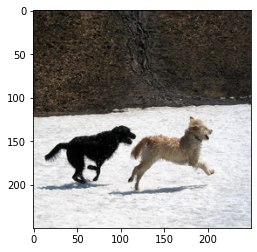

In [ ]:
test_image = Image.open('./images/'+image)
test_image_resized = test_image.resize((250, 250))
plt.imshow(test_image_resized)
plt.show()

In [ ]:
test_pred.detach().numpy()

array([[4480., 4480., 4480., 4480., 4480., 4480., 4480., 4480., 4480.,
        4480.]], dtype=float32)

In [ ]:
test_caption = "<start> "
for word_ind in test_pred.detach().numpy()[0]:
    test_caption += id_to_word[word_ind]
    test_caption += " "        
print(test_caption)

<start> brown brown brown brown brown brown brown brown brown brown 
